# TRAFFIC SIGN RECOGNITION GERMAN DATASET

## INDICE
 0. CARGA DE DATOS
 1. MODELO
 2. VISUALIZACIÓN DE LOS PESOS   
 3. CONFUSSION MATRIX
 4. PORCENTAJE DE ACIERTOS

## 1. CARGA DE DATOS

In [1]:
import os
import glob
import time
import skimage.data
import skimage.transform
#import sklearn.preprocessing
import random
import skimage.data
import skimage.transform
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.contrib import layers
import pandas as pd
import csv
import math
from IPython import display

# Allow image embeding in notebook
%matplotlib inline

D:\ANACONDA\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def load_data(data_dir):
    directories = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d))]

    labels = []
    images = []
    #print(directories)
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f) 
                      for f in os.listdir(label_dir) if f.endswith(".ppm")]
        for f in file_names:
            images.append(skimage.data.imread(f))
            labels.append(int(d))
    
    images32 = [skimage.transform.resize(image, (32, 32))for image in images]
    
    labels2=np.array(labels)
    images2=np.array(images32)
    
    #print(label_dir)
    return images2, labels2

In [3]:
train_data_dir = ".\\data\\Training"            
X_train_orig, Y_train_orig = load_data(train_data_dir)
#print(Y_train_orig)

D:\ANACONDA\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [4]:
def load_test_data (data_dir):
    labels  = []
    labels2 =[]
    images = []
    
    with open('GT-final_test.csv', 'r') as f:
      reader = csv.reader(f)
      labels = list(reader)
    #print(labels)
    for d in range(1,len(labels)):
        labels2.append(int(labels[d][0]))
    #print(len(labels))
    
    file_names = [os.path.join(data_dir, f) 
                  for f in os.listdir(data_dir) if f.endswith(".ppm")]
    for f in file_names:
        images.append(skimage.data.imread(f))
        
    images32 = [skimage.transform.resize(image, (32, 32))
                for image in images]
    
    labels3=np.array(labels2)
    images2=np.array(images32)
    
    return images2,labels3

In [5]:
test_data_dir = ".\\data\\Testing" 
X_test_orig, Y_test_orig = load_test_data(test_data_dir)

D:\ANACONDA\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


## 2. MODEL 4: DEEP NEURAL NETWORK

In [7]:
# TensorFlow doesn't have a native implementation of Leaky-ReLU
# that I know of. But it's simple enough to add it.
def lrelu(x):
    return tf.maximum(0.01*x,x)

In [8]:
from tensorflow.contrib import layers
import time

In [9]:
class Model4():
    def conv(self, input, num_outputs, name=None):
        return layers.convolution2d(
            input, num_outputs=num_outputs, kernel_size=(5,5), stride=(1,1),
            padding='SAME', activation_fn=lrelu, normalizer_fn=layers.batch_norm
            )
    def pool(self, input):
        return layers.max_pool2d(input, kernel_size=(2,2),
                                stride=(2,2), padding='SAME')
    def __init__(self):
        #History of training state as tuples (step, loss, accuracy, training loss, time)
        self.train_log =[]
        self.train_time=[]
        
        self.graph = tf.Graph()
        with self.graph.as_default():
            #Global step counter
            self.global_step = tf.Variable(0, trainable=False, name='global_step')
            #Placeholders
            self.images=tf.placeholder(tf.float32, (None, 32,32,3), name='images')
            self.labels=tf.placeholder(tf.int32, (None), name='labels')
            #Block input shape [32,32,3], output shape [16,16,16]
            self.conv1 = self.conv(self.images,8)
            self.pool1=self.pool(self.conv1)
            #Block input shape: [16,16,16], output shape [8,8,32]
            self.conv2=self.conv(self.pool1,12)
            self.pool2=self.pool(self.conv2)
            #Block input shape: [8,8,32], ouutput shpae [4,4,64]
            self.conv3=self.conv(self.pool2,16)
            self.pool3=self.pool(self.conv3)
            #Fully connected layer
            self.flat=layers.flatten(self.pool3)
#            self.hl=layers_fully:connected(sefl.flat,200,lrelu)
            #self.shapeflat=self.flat.shape
            self.logits = layers.fully_connected(self.flat,43,lrelu)
            #Convert one hot vector to label index
            self.predicted_labels=tf.argmax(self.logits,1)
            #Loss
            self.loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
                    logits=self.logits, labels=self.labels))
            #Training OP
            self.train=tf.train.AdamOptimizer(learning_rate=0.001)\
                                .minimize(self.loss, global_step=self.global_step)
            #Initialization Op
            self.init=tf.global_variables_initializer()
            #Create session
            self.session=tf.Session()
            #Run initialization Op
            self.session.run(self.init)

In [10]:
def train_graph(model, train_images, train_labels, val_images, Val_labels, train_count, imprimir=True):
    t_start=time.time()
    #Training loop
    for i in range(1, train_count+1):
        ##??? improve picking batches
        #COGEMOS UN PEQUEÑO BATCH DE 100 IMAGENES RANDOM
        indexes = np.random.choice(np.arange(train_images.shape[0]),100,replace=False)
        batch_images=train_images[indexes]
        batch_labels=train_labels[indexes]
        #ENTRENAMOS ESTE BATCH CON NUESTRO MODELO
        _, loss = model.session.run([model.train, model.loss], {
            model.images:batch_images,
            model.labels:batch_labels,
            })
        # Evaluate
        if i % 50 == 0:
            evaluate_graph(model, batch_images, batch_labels, val_images, Val_labels, t_start)
    #Final evalution
    evaluate_graph(model, batch_images, batch_labels, val_images, Val_labels, t_start, imprimir=True)
    #shape = model.session.run([model.shapeflat], {
    #        model.images:batch_images,
    #        model.labels:batch_labels,
    #        })
    #print(shape)

def evaluate_graph(model, train_images, train_labels, val_images, val_labels, training_time, imprimir=False):
    #Run predicionts against a batch of the training set
    train_predicted, train_loss, step = model.session.run(
        [model.predicted_labels, model.loss, model.global_step],
        {model.images:train_images, model.labels:train_labels})
    
    #Run predictions against the full test set
    val_predicted, val_loss = model.session.run(
            [model.predicted_labels, model.loss],
            {model.images: val_images, model.labels:val_labels})
    
    #Calculate accuracy
    train_accuracy=np.sum(train_labels == train_predicted) / train_labels.shape[0]
    val_accuracy = np.sum(val_labels == val_predicted) / val_labels.shape[0]
    #Append to train log
    model.train_log.append((step, train_loss, train_accuracy, val_loss, val_accuracy, training_time))
    #Plot
    draw_graph(model.train_log)
    
    if imprimir == True:
        print("{:4}, Loss: {:.3f}  Train set accuracy: {:.3f}".format(step,train_loss, train_accuracy))
        print("{:4}, Loss: {:.3f}  Validation set accuracy: {:.3f}".format(step ,val_loss, val_accuracy))

def draw_graph(logs):
    #Expand log tuples to lists
    steps, train_losses, train_accuracies, val_losses, val_accuracies, times = zip(*logs)
    #Clear output
    display.clear_output(wait=True)
    fig, (ax1,ax2) = plt.subplots(2,sharex=True,figsize=(8,6))
    #Graph 1: Accuracies
    ax1.set_title("Step: {}     Training Time:  {:.0f}  seconds\n"\
                  "Training Accuracy: {:.3f}    Validation Accuracy: {:.3f}"\
                  .format(steps[-1], times[-1], train_accuracies[-1], val_accuracies[-1]), 
                  fontsize=5)
    ax1.plot(steps, train_accuracies, label="Training Accuray")
    ax1.plot(steps, val_accuracies, label="Validation Accuracy")
    ax1.set_ylabel("Accuracy")
    ax1.legend(fontsize=8, loc="lower right")
#    ax1.set_y1(0,1.1)
    #Graph 2 : Losses
    ax2.set_title("Training loss: {:.3f} Validation Loss: {:.3}"\
                 .format(train_losses[-1],val_losses[-1]),fontsize=5)
    ax2.set_yscale('log')
    ax2.plot(steps, train_losses, label="Training loss")
    ax2.plot(steps,val_losses, label="Validation Loss")
    ax2.set_ylabel("Loss")
    ax2.legend(fontsize=8, loc='lower left')
    ax2.set_xlabel("Steps")
    _ = plt.show()

In [10]:
m4=Model4()

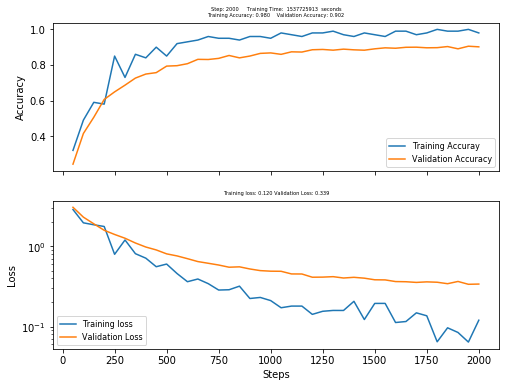

2000, Loss: 0.120  Train set accuracy: 0.980
2000, Loss: 0.339  Validation set accuracy: 0.902


In [11]:
train_graph(m4, X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, 2000)

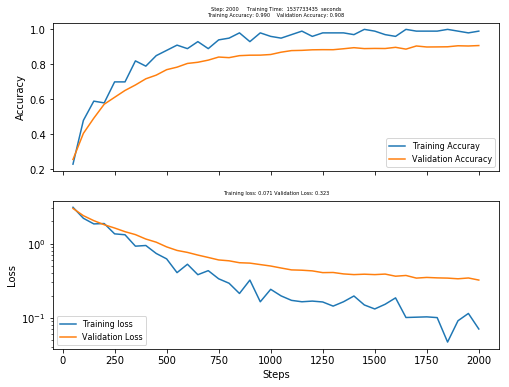

2000, Loss: 0.071  Train set accuracy: 0.990
2000, Loss: 0.323  Validation set accuracy: 0.908


In [26]:
m4_1=Model4()
train_graph(m4_1, X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, 2000)

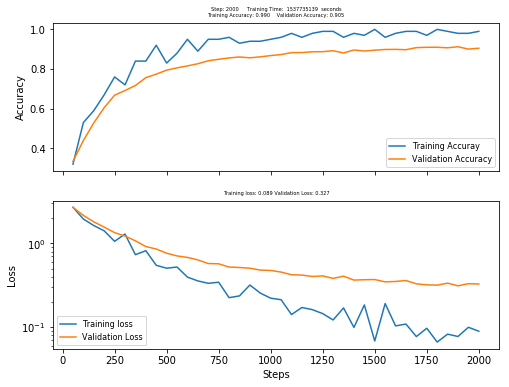

2000, Loss: 0.089  Train set accuracy: 0.990
2000, Loss: 0.327  Validation set accuracy: 0.905


In [27]:
m4_2=Model4()
train_graph(m4_2, X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, 2000)

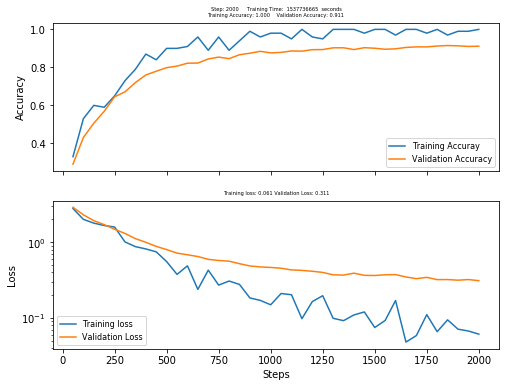

2000, Loss: 0.061  Train set accuracy: 1.000
2000, Loss: 0.311  Validation set accuracy: 0.911


In [28]:
m4_3=Model4()
train_graph(m4_3, X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, 2000)

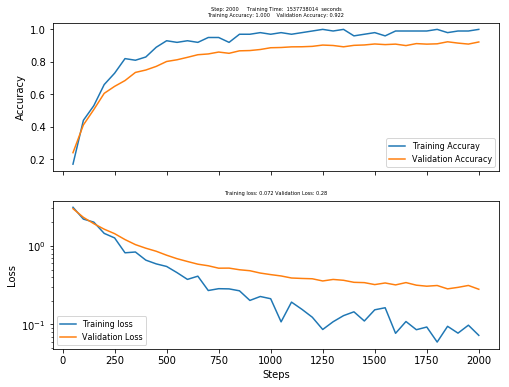

2000, Loss: 0.072  Train set accuracy: 1.000
2000, Loss: 0.280  Validation set accuracy: 0.922


In [29]:
m4_4=Model4()
train_graph(m4_4, X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, 2000)

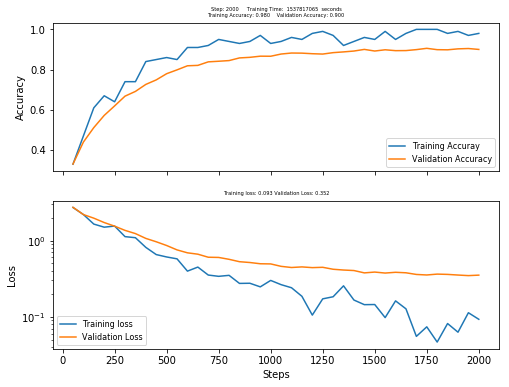

2000, Loss: 0.093  Train set accuracy: 0.980
2000, Loss: 0.352  Validation set accuracy: 0.900


In [11]:
m4_5=Model4()
train_graph(m4_5, X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, 2000)

### ANALISIS DEL TAMAÑO DE LAS CAPAS

In [ ]:
class Model4(n1,n2,n3):
    def conv(self, input, num_outputs, name=None):
        return layers.convolution2d(
            input, num_outputs=num_outputs, kernel_size=(5,5), stride=(1,1),
            padding='SAME', activation_fn=lrelu, normalizer_fn=layers.batch_norm
            )
    def pool(self, input):
        return layers.max_pool2d(input, kernel_size=(2,2),
                                stride=(2,2), padding='SAME')
    def __init__(self):
        #History of training state as tuples (step, loss, accuracy, training loss, time)
        self.train_log =[]
        self.train_time=[]
        
        self.graph = tf.Graph()
        with self.graph.as_default():
            #Global step counter
            self.global_step = tf.Variable(0, trainable=False, name='global_step')
            #Placeholders
            self.images=tf.placeholder(tf.float32, (None, 32,32,3), name='images')
            self.labels=tf.placeholder(tf.int32, (None), name='labels')
            #Block input shape [32,32,3], output shape [16,16,16]
            self.conv1 = self.conv(self.images,n1)
            self.pool1=self.pool(self.conv1)
            #Block input shape: [16,16,16], output shape [8,8,32]
            self.conv2=self.conv(self.pool1,n2)
            self.pool2=self.pool(self.conv2)
            #Block input shape: [8,8,32], ouutput shpae [4,4,64]
            self.conv3=self.conv(self.pool2,n3)
            self.pool3=self.pool(self.conv3)
            #Fully connected layer
            self.flat=layers.flatten(self.pool3)
#            self.hl=layers_fully:connected(sefl.flat,200,lrelu)
            #self.shapeflat=self.flat.shape
            self.logits = layers.fully_connected(self.flat,43,lrelu)
            #Convert one hot vector to label index
            self.predicted_labels=tf.argmax(self.logits,1)
            #Loss
            self.loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
                    logits=self.logits, labels=self.labels))
            #Training OP
            self.train=tf.train.AdamOptimizer(learning_rate=0.001)\
                                .minimize(self.loss, global_step=self.global_step)
            #Initialization Op
            self.init=tf.global_variables_initializer()
            #Create session
            self.session=tf.Session()
            #Run initialization Op
            self.session.run(self.init)

In [65]:
def evaluate(model, train_images, test_images, train_labels, test_labels, step, imprimir=True):
    #Run predictions against the full test set
    predicted_train, loss_train = model.session.run([model.predicted_labels, model.loss],
                                       {model.images: train_images, model.labels:train_labels})
    predicted_test, loss_test = model.session.run([model.predicted_labels, model.loss],
                                       {model.images: test_images, model.labels:test_labels})
    #Calculate accuracy and print
    accuracy_train=np.sum(train_labels == predicted_train)/train_labels.shape[0]
    accuracy_test=np.sum(test_labels == predicted_test)/test_labels.shape[0]
    #accuracy=np.sum(labels == predicted)/labels.shape[0]
    if imprimir == True:
        print("{:4}, Loss: {:.3f}  Train accuracy: {:.3f}".format(step,loss_train, accuracy_train))
        print("{:4}, Loss: {:.3f}  Test accuracy: {:.3f}".format(step ,loss_test, accuracy_test))
        
    return loss_test

def train_minibatch(model, images, labels, test_images, test_labels, train_counts, imprimir=True):
    #Training loop
    costs = []
    for i in range(train_counts):
        if i % 300 == 0:
            lossvalue = evaluate(model, images, test_images, labels, test_labels, model.session.run(model.global_step),imprimir)
        # ??? improve picking batches
        costs.append(lossvalue)
        indexes = np.random.choice(np.arange(images.shape[0]), 50, replace=False)
        #print("indexes" , indexes.shape)
        model.session.run(model.train,
                          {model.images: images[indexes],
                           model.labels: labels[indexes]})
    # Final evaluation
    lossvalue = evaluate(model, images, test_images, labels, test_labels, model.session.run(model.global_step))
    costs.append(lossvalue)
    
    #if imprimir == True:
        # plot the cost    
        #plt.plot(np.squeeze(costs))
        #plt.ylabel('cost')
        #plt.xlabel('iterations (per tens)')
        #plt.show()
        

In [ ]:
INTENTOS=[]
for i in range(23):
    n1=2000-i*50
    for j in range(20):
        n2=1000-j*50
        for k in range(10):
            n3=500-k*45
            print("***INTENTO ",i,"***")
            print("n1: ",n1)
            print("n2: ",n2)
            print("n3: ",n3)
            m3 = Model3(n1,n2,n3)
            train_minibatch(m3, X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, 100, True)
            y_pred, _ = m3.session.run([m3.predicted_labels, m3.loss],
                                       {m3.images: X_test_orig, m3.labels:Y_test_orig})
            accuracy=np.sum(Y_test_orig == y_pred)/Y_test_orig.shape[0]
            INTENTOS.append([n1,n2,n3,accuracy,y_pred])

In [ ]:
RESULTADOS=[]
for i in range(39):
    n1=2000-i*50
    for j in range(19):
        n2=1000-j*50
        n3=43
        print("***INTENTO ",i,",",j,"***")
        print("n1: ",n1)
        print("n2: ",n2)
        print("n3: ",n3)
        m3 = Model3(n1,n2,n3)
        train_minibatch(m3, X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, 1000, True)
        y_pred = m3.session.run([m3.predicted_labels, m3.loss],{m3.images: X_test_orig, m3.labels:Y_test_orig})
        acc=np.sum(Y_test_orig == y_pred)/Y_test_orig.shape[0]
        RESULTADOS.append([n1,n2,n3,acc,y_pred])

## CONFUSSION MATRIX

In [18]:
print(__doc__)

#import sklearn
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

Automatically created module for IPython interactive environment


In [19]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization
[[ 29  16   0 ...   0   0   0]
 [  0 679  12 ...   1   0   0]
 [  0  26 693 ...   0   0   0]
 ...
 [  0   0   0 ...  78   0   0]
 [  0   0   0 ...   0  41   2]
 [  0   0   0 ...   0  10  59]]


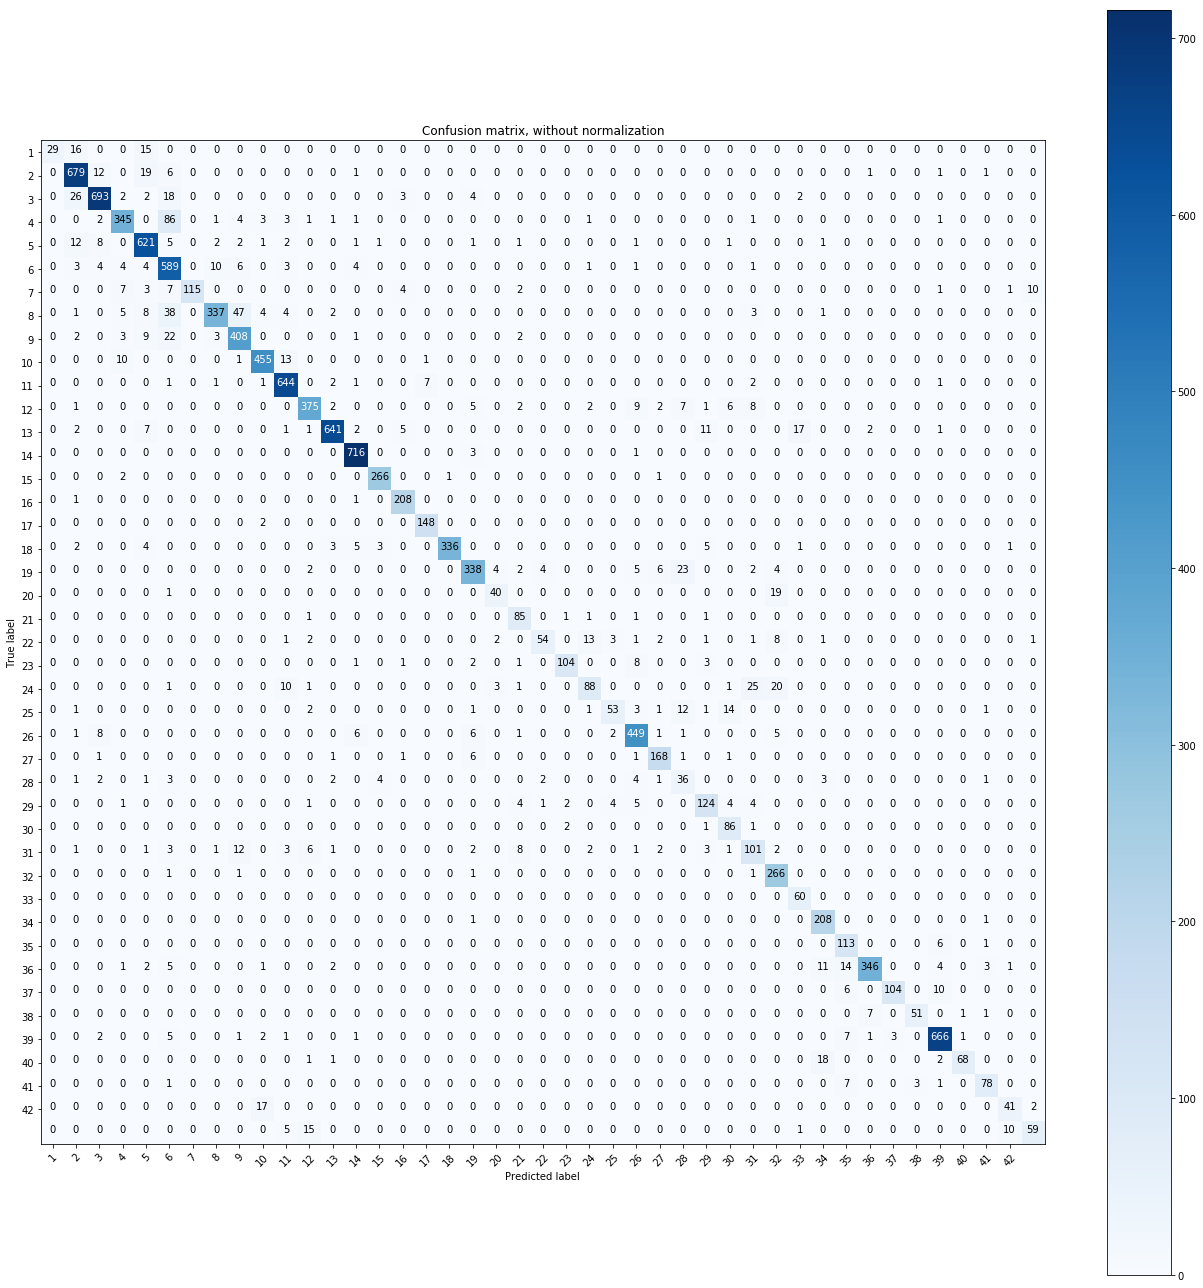

In [20]:
y_pred, _ = m4.session.run([m4.predicted_labels, m4.loss],
                                       {m4.images: X_test_orig, m4.labels:Y_test_orig})

y_test = Y_test_orig

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

class_names= list(range(1,43))

#Plot non-normalized confusion matrix
plt.figure(figsize=(18,18))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')


plt.show()

## PORCENTAJE DE ACIERTOS

In [22]:
def display_aciertos(images, titles=None, cols=5, interpolation=None):
    """ 
    images: A list of images. It can be either:
        + A list of Numpy arrays. Each array represents an image.
        + A list of lists of numpy arrays. In this casse, the images in the inner
          the inner lists are concatentated to make one image.
    
    """
    
    titles = titles or [""] * len(images)
    rows = math.ceil(len(images)/(cols))
    height_ratio =1.2*(rows/cols)*(0.5 if type(images[0]) is not np.ndarray else 1)
    plt.figure(figsize=(11,11 * height_ratio))
    i=1
    for image, title in zip(images, titles):
        plt.subplot(rows, cols, i)
        plt.axis("off")
        if type(image) is not np.ndarray:
            image = [normalize(g) for g in image]
            image = np.concatenate(image, axis=1)
        else:
            image = normalize(image)
        plt.title(title, fontsize = 10)
        plt.imshow(image, cmap="Greys_r", interpolation=interpolation)
        i += 1

In [23]:
label_exemplars_test =[]
for i in range(43):
    for w in range(len(Y_test_orig)):
        if Y_test_orig[w] == i:
            label_exemplars_test.append(X_test_orig[w])
            break

In [24]:
label_count_test = []
for i in range(43):
    label_count_test.append(0)
    for w in range(len(Y_test_orig)):
        if Y_test_orig[w] == i:
            label_count_test[i] = label_count_test[i]+1

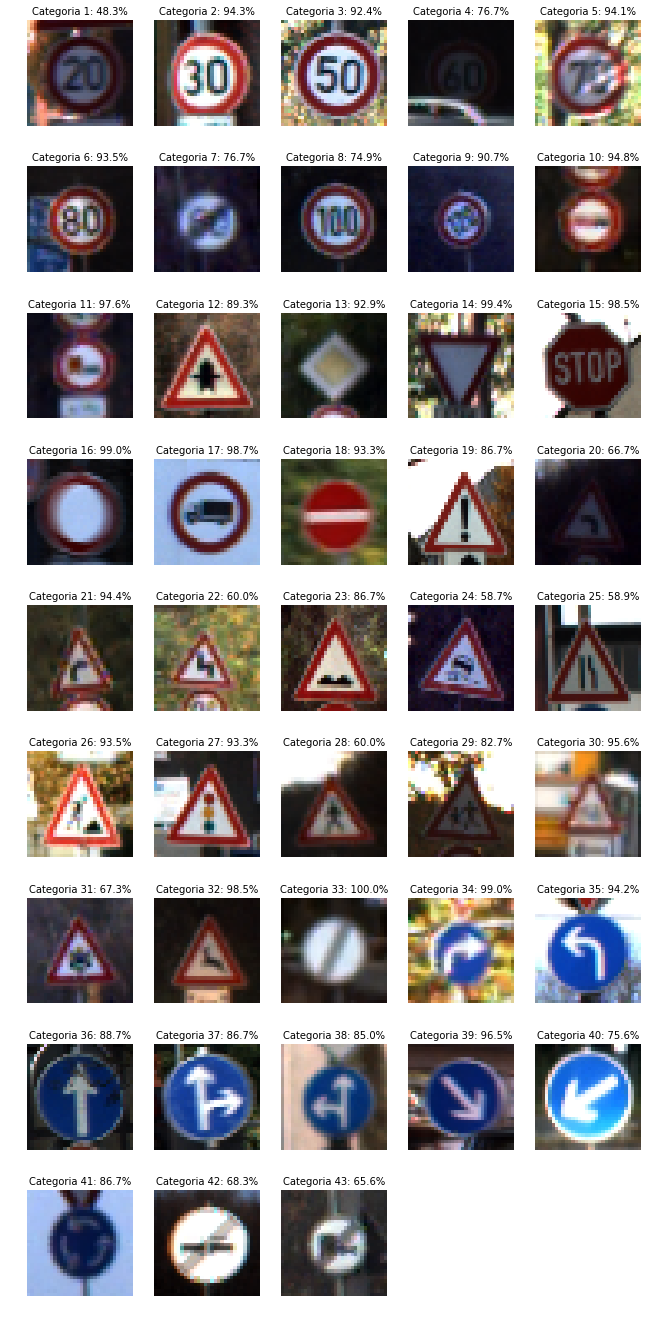

In [25]:
aciertos = [round(cnf_matrix[i,i]/label_count_test[i]*100,1) for i in range(43)]
aciertos = [str(round(cnf_matrix[i,i]/label_count_test[i]*100,1)) for i in range(43)]
titles = [("Categoria "+str(i+1)+": "+aciertos[i]+"%") for i in range(43)]
display_aciertos(label_exemplars_test, titles)